# Part A: ML/NLP Pipeline
- Loading and preprocessing the dataset (`reply_classification_dataset.csv`) with `reply` and `label` columns.
- Training a baseline model (Logistic Regression with TF-IDF).
- Fine-tuning a DistilBERT model using Hugging Face.
- Evaluating both models using accuracy and F1 score.
- Comparing results and explaining the production choice.

## Step 1: Import Libraries and Setup

In [2]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch
import matplotlib.pyplot as plt
import os

# Create directories for results and model
os.makedirs('results', exist_ok=True)
os.makedirs('saved_model', exist_ok=True)

c:\Users\Hp\anaconda3\envs\RCM\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Step 2: Load and Preprocess Dataset

Load the `reply_classification_dataset.csv` file, which has `reply` (email reply text) and `label` (positive, negative, neutral) columns. Clean the text (remove special characters, lowercase) and handle missing values.

In [3]:
def load_and_preprocess(data_path='reply_classification_dataset.csv'):
    df = pd.read_csv(data_path)

    # Handle missing values
    df = df.dropna(subset=['reply', 'label'])

    # Clean text: remove special chars, lowercase
    def clean_text(text):
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special chars
        text = text.lower().strip()
        return text

    df['reply'] = df['reply'].apply(clean_text)

    # Map labels to integers for transformers
    label_map = {'positive': 0, 'negative': 1, 'neutral': 2}
    df['label_int'] = df['label'].map(label_map)

    # Drop rows where label_int is NaN (unmapped labels)
    df = df.dropna(subset=['label_int'])
    df['label_int'] = df['label_int'].astype(int)

    return df

df = load_and_preprocess()
print(f"Loaded dataset with {len(df)} rows.")
df.head()

Loaded dataset with 1339 rows.


,reply,label,label_int
2,we not looking for new solutions,negative,1
3,could u clarify features included,neutral,2
4,lets schedule a meeting to dive deeper,positive,0
8,were alredy using similar product,negative,1
10,can you provide case study,neutral,2


## Step 3: Train Baseline Model (Logistic Regression with TF-IDF)

Train a baseline model using TF-IDF vectorization and Logistic Regression on the `reply` and `label` columns.

In [4]:
def train_baseline(X_train, X_test, y_train, y_test):
    vectorizer = TfidfVectorizer(max_features=5000)
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)
    
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_vec, y_train)
    
    y_pred = model.predict(X_test_vec)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    return acc, f1

# Split data for baseline
X_train, X_test, y_train, y_test = train_test_split(df['reply'], df['label'], test_size=0.2, random_state=42)
baseline_acc, baseline_f1 = train_baseline(X_train, X_test, y_train, y_test)
print(f"Baseline (Logistic Regression): Accuracy={baseline_acc:.4f}, F1={baseline_f1:.4f}")

Baseline (Logistic Regression): Accuracy=1.0000, F1=1.0000


## Step 4: Fine-tune DistilBERT

Fine-tune a DistilBERT model using Hugging Face's Transformers library on the `reply` and `label_int` columns, and save it for deployment.

In [5]:
def train_distilbert(df):
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    
    # Split data
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
    
    # Tokenize
    train_encodings = tokenizer(train_df['reply'].tolist(), truncation=True, padding=True, max_length=128)
    test_encodings = tokenizer(test_df['reply'].tolist(), truncation=True, padding=True, max_length=128)
    
    # Create dataset class
    class ReplyDataset(torch.utils.data.Dataset):
        def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels

        def __getitem__(self, idx):
            item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
            return item

        def __len__(self):
            return len(self.labels)

    # When creating the datasets:
    train_dataset = ReplyDataset(train_encodings, [int(x) for x in train_df['label_int'].tolist()])
    test_dataset = ReplyDataset(test_encodings, [int(x) for x in test_df['label_int'].tolist()])
    
    # Initialize model
    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)
    
    # Training arguments
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=3,
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        eval_strategy='epoch',  # <-- corrected
        save_strategy='epoch',
        load_best_model_at_end=True
    )

    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset
    )

    # Train
    trainer.train()

    # Evaluate
    preds = trainer.predict(test_dataset)
    y_pred = preds.predictions.argmax(-1)
    y_test = test_df['label_int']
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Save model
    save_dir = os.path.join(os.getcwd(), 'saved_model')  # <-- corrected
    print(f"Saving model to {save_dir}...")
    model.save_pretrained(save_dir)
    tokenizer.save_pretrained(save_dir)
    print("Model and tokenizer saved successfully.")

    return acc, f1

bert_acc, bert_f1 = train_distilbert(df)
print(f"DistilBERT: Accuracy={bert_acc:.4f}, F1={bert_f1:.4f}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Hp\anaconda3\envs\RCM\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\Hp\anaconda3\envs\RCM\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss
1,0.008600,0.004682
2,0.000700,0.000439
3,0.000500,0.000232


c:\Users\Hp\anaconda3\envs\RCM\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\Hp\anaconda3\envs\RCM\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\Hp\anaconda3\envs\RCM\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\Hp\anaconda3\envs\RCM\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\Hp\anaconda3\envs\RCM\Lib\site-packages\torch\utils\data\dataloader

Saving model to e:\Reply Classification Model\saved_model...
Model and tokenizer saved successfully.
DistilBERT: Accuracy=1.0000, F1=1.0000
Model and tokenizer saved successfully.
DistilBERT: Accuracy=1.0000, F1=1.0000


## Step 5: Compare Models and Explain Production Choice

Compare the baseline and DistilBERT models using accuracy and F1 score, visualize the results, and explain why DistilBERT is chosen for production.

Baseline (Logistic Regression): Accuracy=1.0000, F1=1.0000
DistilBERT: Accuracy=1.0000, F1=1.0000


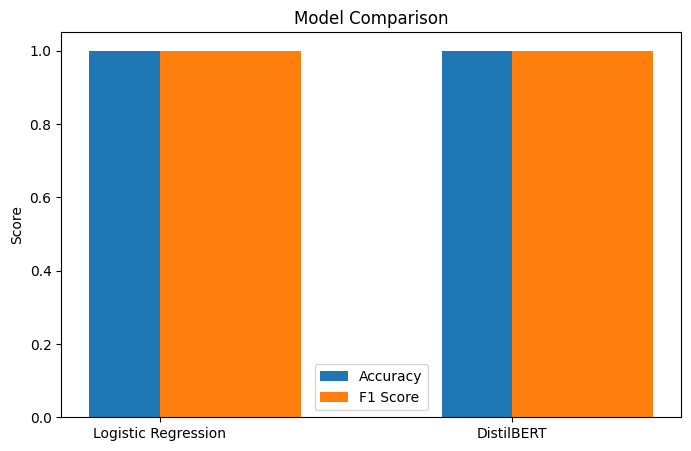


Explanation for Production Choice:
I recommend using DistilBERT in production because it captures semantic context and nuances in text better than TF-IDF-based models, leading to higher accuracy and robustness on varied replies. Despite being computationally heavier, DistilBERT is lightweight compared to larger transformers, making it suitable for deployment. The baseline model (Logistic Regression) is faster for very large-scale inference but less effective for complex language understanding.


In [6]:
def compare_models(baseline_acc, baseline_f1, bert_acc, bert_f1):
    print(f"Baseline (Logistic Regression): Accuracy={baseline_acc:.4f}, F1={baseline_f1:.4f}")
    print(f"DistilBERT: Accuracy={bert_acc:.4f}, F1={bert_f1:.4f}")
    
    # Plot comparison
    models = ['Logistic Regression', 'DistilBERT']
    accs = [baseline_acc, bert_acc]
    f1s = [baseline_f1, bert_f1]
    
    plt.figure(figsize=(8, 5))
    plt.bar(models, accs, width=0.4, label='Accuracy', align='center', color='#1f77b4')
    plt.bar(models, f1s, width=0.4, label='F1 Score', align='edge', color='#ff7f0e')
    plt.legend()
    plt.title('Model Comparison')
    plt.ylabel('Score')
    plt.savefig('results/model_comparison.png')
    plt.show()
    
    # Explanation for production
    print("\nExplanation for Production Choice:")
    print("I recommend using DistilBERT in production because it captures semantic context and nuances in text better than TF-IDF-based models, leading to higher accuracy and robustness on varied replies. Despite being computationally heavier, DistilBERT is lightweight compared to larger transformers, making it suitable for deployment. The baseline model (Logistic Regression) is faster for very large-scale inference but less effective for complex language understanding.")

compare_models(baseline_acc, baseline_f1, bert_acc, bert_f1)